In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Реализовать решение задачи Cliff методами:

<li>SARSA
<li>Q-обучение
<li>Любым другим методом используя библиотеку 

## функции для реализации эпизода хождения по полю

In [5]:
#генирация поля
def genirate_field(n=4,m=12):
    field = np.ones((n,m))
    field[(n-1):,1:-1] = [0]*(m-2)
    return field

#смена координаты игрока
def change_coordinate(act, coordinate, field_shape):
    cord = coordinate.copy()
    if act=='l':
        cord[1] -= 1 
    elif act == 'r':
        cord[1] += 1
    elif act == 't':
        cord[0] -= 1
    elif act == 'd':
        cord[0] += 1    
    if((cord[0]< field_shape[0]) and (cord[1]< field_shape[1]))and (cord[0]>=0 and cord[1]>=0):
        return cord
    else:
        return coordinate
#получение вознаграждения за действие и флаг конца эпизода
def get_reward(coordinate,field):
    reward = 0 
    if field[coordinate[0],coordinate[1]]==0:
        reward = -100
        end_game = True
    elif coordinate == [field.shape[0]-1,field.shape[1]-1]:
        reward = -1
        end_game = True
    else:
        reward = -1
        end_game = False
    return [reward, end_game]
#делаем шаг, проверяем на конец эпизода, получаем выигрыш
def step(act, state, field_shape,field):
    new_cord = change_coordinate(act, state, field_shape)
    return get_reward(new_cord, field)+ [new_cord]

#таблица состояний и наград за действия
def genirate_table_states_q(shape):
    coord = [[i,j] for i in range(shape[0]) for j in range(shape[1]) ]

    states_table = pd.DataFrame()
    states_table['l'] = [0.]*48
    states_table['t'] = [0.]*48
    states_table['r'] = [0.]*48
    states_table['d'] = [0.]*48
    states_table['d'] = [0.]*48
    states_table['coordinate'] = coord
    states_table['coordinate']=states_table['coordinate'].astype(str)
    return states_table

#выбор действия
def chose_next_step(q_states_tab, state, eps = 0.1):
    states_l=['l','t','r','d']
    if np.random.random() < eps:
        act = np.random.choice(4)
        return states_l[act]
    else:
        i = q_states_tab[q_states_tab['coordinate']== str(state)][['l','t','r','d']].values.argmax()
        return states_l[i]

## Функции отрисовки графиков

In [133]:
def draw_rewards(rewar_l, algo):
    plt.figure(figsize=(10,5))
    plt.plot(range(len(rewar_l)), rewar_l,alpha=.5, label=algo)
    plt.legend()
    plt.title("Вознаграждение от эпизодов")
    plt.xlabel("Эпизод")
    plt.ylabel("Вознаграждение")
    plt.show()
    
def draw_stratege(strat, algo, i=None):
    y_ar, x_ar=[],[]
    if i==None:
        strat_1 = strat
    else:
        strat_1 = strat[i]
    for y,x in strat_1:
        y_ar.append(3-y)
        x_ar.append(x)

    plt.figure(figsize=(10,5))
    plt.plot(x_ar,y_ar,alpha=.5, label=algo, linewidth=5)
    plt.plot(range(1,11), [0]*10, alpha=.5, c='r',linewidth=10,label='Обрыв')
    plt.ylim([0,4])
    plt.xlim([-1,12])
    plt.yticks(range(5))
    plt.xticks(range(12))
    plt.legend()
    plt.title("Cтратегия "+ str(i))
    plt.grid()
    plt.show()

def draw_strateges(strat_sarsa, strat_Q, algo,i_s=None,i_q=None):
    y_ar_s, x_ar_s=[],[]
    
    if i_s==None:
        strat_1 = strat_sarsa
    else:
        strat_1 = strat_sarsa[i_s]
        
    if i_q==None:
        strat_q = strat_Q
    else:
        strat_q = strat_Q[i_q]
        
    for y,x in strat_1:
        y_ar_s.append(3-y)
        x_ar_s.append(x)
        
    y_ar_q, x_ar_q=[],[]
    for y,x in strat_q:
        y_ar_q.append(3-y)
        x_ar_q.append(x)   
    

    plt.figure(figsize=(10,5))
    plt.plot(x_ar_s,y_ar_s,alpha=.5, label=algo[0], linewidth=5)
    plt.plot(x_ar_q,y_ar_q,alpha=.5, label=algo[1], linewidth=5)
    
    plt.plot(range(1,11), [0]*10, alpha=.5, c='r',linewidth=10,label='Обрыв')
    plt.ylim([0,4])
    plt.xlim([-1,12])
    plt.yticks(range(5))
    plt.xticks(range(12))
    plt.legend()
    plt.title("Лучшие стратегии")
    plt.grid()
    plt.show()
    
def draw_rewards_algo(rewar_s,rewar_q, algo):
    plt.figure(figsize=(10,5))
    plt.plot(range(len(rewar_s)), rewar_s,alpha=.5, label=algo[0])
    plt.plot(range(len(rewar_q)), rewar_q,alpha=.5, label=algo[1])
    plt.legend()
    plt.title("Вознаграждение от эпизодов")
    plt.xlabel("Эпизод")
    plt.ylabel("Вознаграждение")
    plt.show()

## Алгоритм SARSA

In [123]:
def sarsa_algoritm(num_episodes=100, render=True, eps=0.1,
               learning_rate=0.1, gamma=0.9):
    
    field_shape = [4,12]
    field = genirate_field(n=4,m=12)
    state_table_q_values = genirate_table_states_q(field_shape)
    ep_rewards = []
    strategs = []
    
    
    for _ in range(num_episodes):  
        done = False
        reward_sum = 0
        state = [3,0]
        action = chose_next_step(state_table_q_values, state, eps)
        state_list=[]
        state_list.append(state)
        while not done: 
            reward, done, next_state = step(action, state, field_shape,field)
            next_action = chose_next_step(state_table_q_values, next_state, eps)
            
            reward_sum += reward
            index = state_table_q_values[state_table_q_values['coordinate']== str(state)].index[0]
            index_next = state_table_q_values[state_table_q_values['coordinate']== str(next_state)].index[0]
                  
            td_target = reward + 0.9 * state_table_q_values.loc[index_next][next_action]
            
            td_error = td_target - state_table_q_values.loc[index][action]
            
            state_table_q_values.loc[index,action] += learning_rate * td_error
            
            state = next_state
            action = next_action
            state_list.append(state)
        
        #print('episod')    
        ep_rewards.append(reward_sum)
        strategs.append(state_list)
    return ep_rewards, strategs

In [87]:
%%time
reward_l=[]
reward_s, strateges_s = sarsa_algoritm(500)

episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod

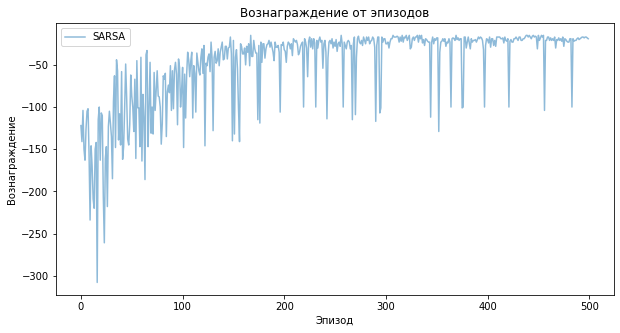

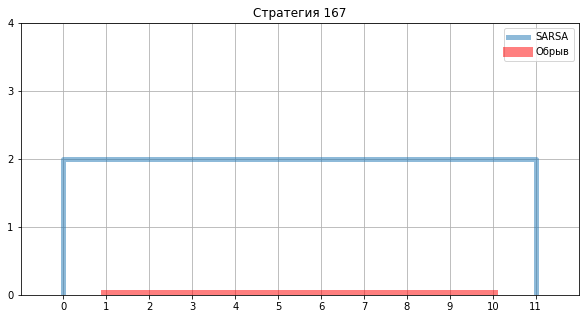

In [88]:
draw_rewards(reward_s, 'SARSA')

optim_stratege_s = reward_s.index(max(reward_s))
draw_stratege(strateges_s,optim_stratege_s,'SARSA')

In [89]:
reward_s[optim_stratege_s]

-15

## Алгоритм Q обучение

In [98]:
def q_algoritm(num_episodes=100, render=True, eps=0.1,
               learning_rate=1, gamma=0.9):
    
    field_shape = [4,12]
    field = genirate_field(n=4,m=12)
    state_table_q_values = genirate_table_states_q(field_shape)
    ep_rewards = []
    strategs = []
    
    
    for _ in range(num_episodes):  
        done = False
        reward_sum = 0
        state = [3,0]
        state_list=[]
        state_list.append(state)
        while not done: 
            action = chose_next_step(state_table_q_values, state, eps)
            reward, done, next_state = step(action, state, field_shape,field)
            reward_sum += reward
            index = state_table_q_values[state_table_q_values['coordinate']== str(state)].index[0]
            index_next = state_table_q_values[state_table_q_values['coordinate']== str(next_state)].index[0]
            # Update q_values       
            td_target = reward + 0.9 * state_table_q_values.loc[index_next][['l','t','r','d']].values.max()
            
            td_error = td_target - state_table_q_values.loc[index][action]
            
            state_table_q_values.loc[index,action] += learning_rate * td_error
            # Update state
            state = next_state
            state_list.append(state)
        
        #print('episod')    
        ep_rewards.append(reward_sum)
        strategs.append(state_list)
    return ep_rewards, strategs

In [83]:
%%time
rewar_l=[]
reward_q, strat_q = q_algoritm(500)


episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod
episod

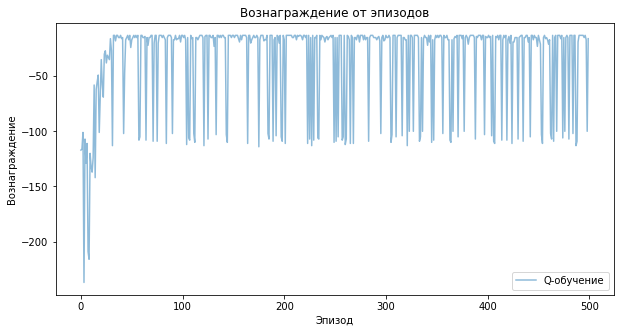

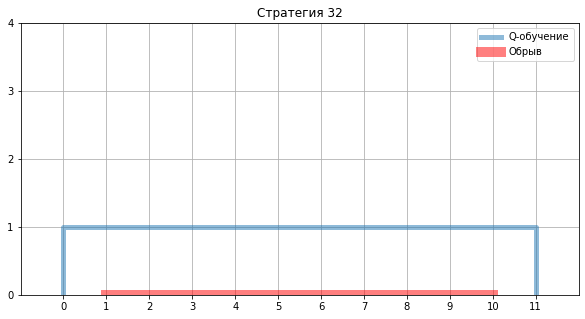

In [85]:
draw_rewards(reward_q,'Q-обучение' )
optim_stratege_q = reward_q.index(max(reward_q))
draw_stratege(strat_q,optim_stratege_q,'Q-обучение')

## Сравнение двух Алгоритмов

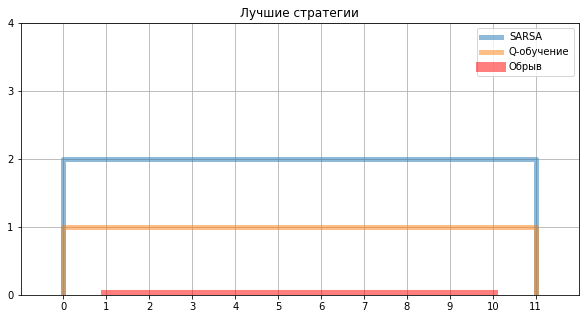

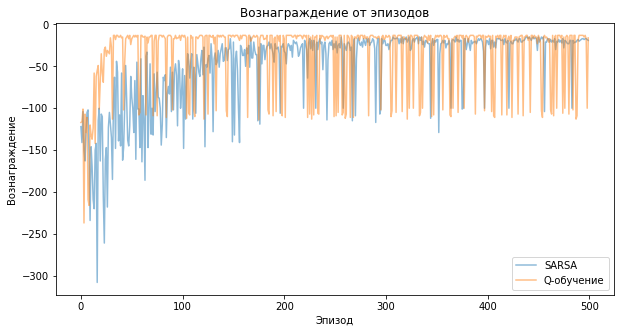

In [92]:
draw_strateges(strateges_s,optim_stratege_s, strat_q,optim_stratege_q, ['SARSA','Q-обучение'])
draw_rewards_algo(reward_s,reward_q, ['SARSA','Q-обучение'])


запустим 500 эпизодов по 40 раз, усредним вознаграждения. Таким образом попробуем приблизить графики к тем, что были в лекции

In [111]:
rewards=[0]*500
max_reward = -1000
optim_stratege_q = []
n=40
for i in range(n):
    reward_q, strat_q = q_algoritm(500)
    max_temp = max(reward_q)
    if max_temp>max_reward:
        optim_stratege_q = strat_q[reward_q.index(max_temp)]
    rewards = np.array(rewards)+np.array(reward_q)
    if i%5==0:
        print(i)
r = rewards/n

0
5
10
15
20
25
30
35


In [126]:
rewards=[0]*500
max_reward = -1000
optim_stratege_s = []
n=40
for i in range(n):
    reward_s, strat_s = sarsa_algoritm(500)
    max_temp = max(reward_s)
    if max_temp>max_reward:
        optim_stratege_s = strat_s[reward_s.index(max_temp)]
    rewards = np.array(rewards)+np.array(reward_s)
    if i%5==0:
        print(i)
r_s = rewards/n

0
5
10
15
20
25
30
35


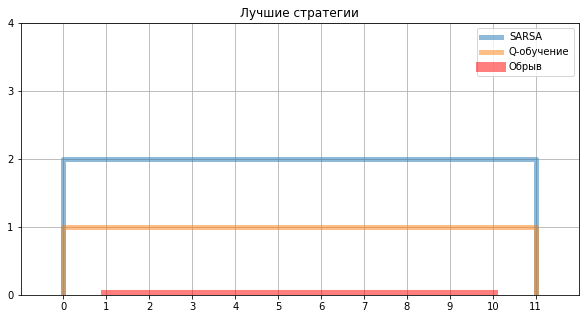

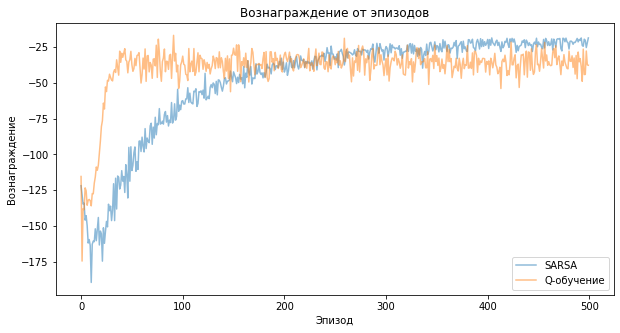

In [134]:
draw_strateges(optim_stratege_s, optim_stratege_q, ['SARSA','Q-обучение'], None, None)

draw_rewards_algo(r_s,r, ['SARSA','Q-обучение'])

## Любым другим методом используя библиотеку RLlib реализовать решение
